# **Advanced Lane Lines Project**

[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

## Camera Calibration

The first major step towards a good lane finding application is having truthworthy data coming in. Due to physical limitations of lenses in cameras we need to first calibrate our camera using `cv2` and some handy pictures of a chessboard.

### First let's import some handy libraries

In [1]:
import pickle
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Find inner corners of chessboard

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
ret = None
corners = []

# Make a list of calibration images
filenames = glob.glob('camera_cal/calibration*.jpg')

img_size = None

for name in filenames:
    img = cv2.imread(name)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = gray.shape[::-1]
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
ret, mtx, dist, _, _2 = cv2.calibrateCamera(
    objpoints,
    imgpoints,
    img_size, 
    None,
    None
)

### Testing Undistort with Calibration Image

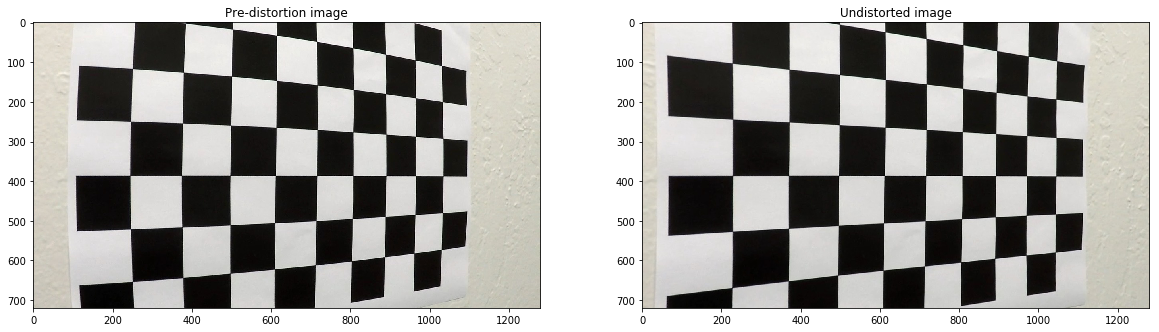

In [3]:
cal_test_image = cv2.imread('camera_cal/calibration5.jpg')
cal_test_image = cv2.cvtColor(cal_test_image, cv2.COLOR_BGR2RGB)
cal_undist = cv2.undistort(cal_test_image, mtx, dist, None, mtx)
fig = plt.figure(figsize=(20,20))
srt = plt.subplot("121")
srt.set_title("Pre-distortion image")
srt.imshow(cal_test_image)
end = plt.subplot("122")
end.set_title("Undistorted image")
end.imshow(cal_undist)
plt.show()

### Testing Undistort with Actual Image

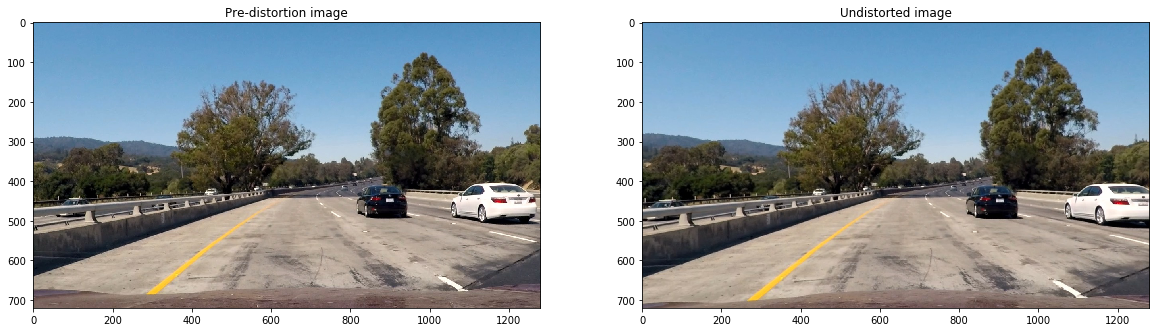

In [4]:
_test_image = cv2.imread('test_images/test1.jpg')
_test_image = cv2.cvtColor(_test_image, cv2.COLOR_BGR2RGB)
_test_undist = cv2.undistort(_test_image, mtx, dist, None, mtx)
fig = plt.figure(figsize=(20,20))
srt = plt.subplot("121")
srt.set_title("Pre-distortion image")
srt.imshow(_test_image)
end = plt.subplot("122")
end.set_title("Undistorted image")
end.imshow(_test_undist)
plt.show()

### Thresholding

In [5]:
def threshold_img(img, s_thresh=(150, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Take S channel
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    # Take the derivative in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine thresholding from S channel binary and X gradient
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

### Testing Threshold with Image

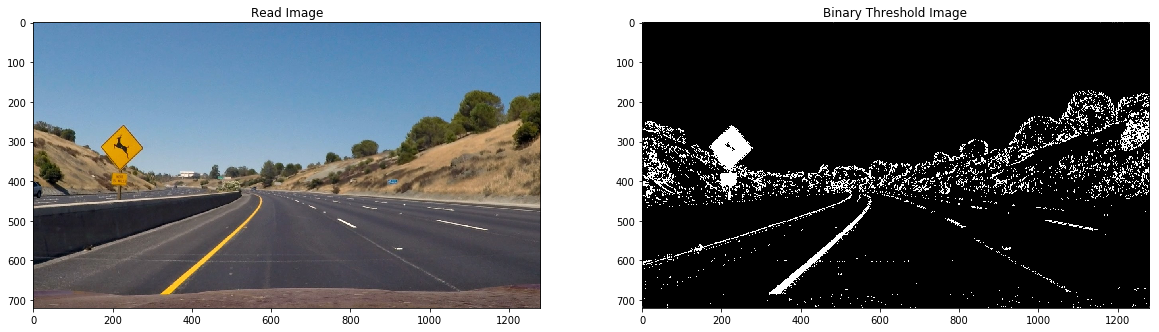

In [6]:
thresh_test_image = cv2.imread('test_images/test2.jpg')
thresh_test_image = cv2.cvtColor(thresh_test_image, cv2.COLOR_BGR2RGB)
thresh_img = threshold_img(thresh_test_image)
fig = plt.figure(figsize=(20,20))
srt = plt.subplot("121")
srt.set_title("Read Image")
srt.imshow(thresh_test_image)
end = plt.subplot("122")
end.set_title("Binary Threshold Image")
end.imshow(thresh_img, cmap='gray')
plt.show()

### Perspective Shift

In [7]:
def perspective_shift(img, src, dest):
    img_size = (img.shape[1], img.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dest)
    
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

### Testing Perspective Shift on Image

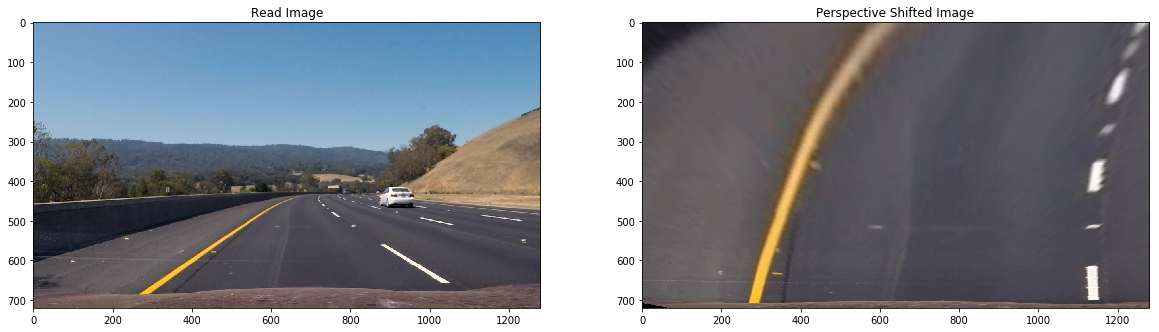

In [8]:
src_corners = np.float32([[225,720],[590,450],[690,450],[1025,720]])
dest_corners = np.float32([[275,720],[275,0],[1025,0],[1025,725]])

per_test_image = cv2.imread('test_images/test3.jpg')
per_test_image = cv2.cvtColor(per_test_image, cv2.COLOR_BGR2RGB)
per_res, M = perspective_shift(per_test_image, src_corners, dest_corners)
fig = plt.figure(figsize=(20,20))
srt = plt.subplot("121")
srt.set_title("Read Image")
srt.imshow(per_test_image)
end = plt.subplot("122")
end.set_title("Perspective Shifted Image")
end.imshow(per_res)
plt.show()

### Pipeline!

In [9]:
def pipeline(img, src_corners, dest_corners):
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    threshold = threshold_img(undist)
    
    warped, M = perspective_shift(threshold, src_corners, dest_corners)
    
    return warped

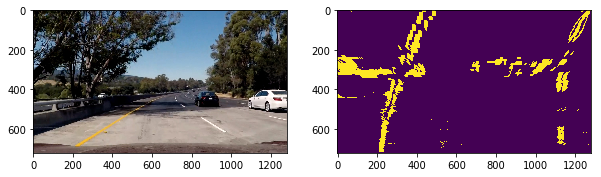

In [10]:
src_corners = np.float32([[225,720],[590,450],[690,450],[1025,720]])
dest_corners = np.float32([[275,720],[275,0],[1025,0],[1025,725]])

test_image = cv2.imread('test_images/test5.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(test_image)
test_image = pipeline(test_image, src_corners, dest_corners)
fig.add_subplot(1,2,2)
plt.imshow(test_image)
plt.show()

### Calculate Radius of Curvature

In [11]:
def rad_curv(ploty, leftx, lefty, rightx, righty):
    y_eval = np.max(ploty)
    
    #Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (left_curverad, right_curverad)

### Draw Curve Lines on Image

In [12]:
def draw_curve_lines(original_img, undist, bin_warped, inv_M):
    binary_warped = np.copy(bin_warped)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 65
    # Set minimum number of pixels found to recenter window
    minpix = 75
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
  
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    cv2.polylines(color_warp, np.int32(pts_left), False, (255,255,0), thickness=50)
    cv2.polylines(color_warp, np.int32(pts_right), False, (0,0,255), thickness=50)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_M, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # LAST STEPS!
    
    # Get radius of curvature
    left_curverad, right_curverad = rad_curv(ploty, leftx, lefty, rightx, righty)
    
    avg_rad_curve = (left_curverad+right_curverad)/2
    
    # Get offset
    lane_center = (right_fitx[ploty.argmax()] + left_fitx[ploty.argmax()])/2 

    abs_middle = 640.0

    offset_px = abs_middle-lane_center

    offset_m = offset_px * 3.7/700

    return (result, avg_rad_curve, offset_m)
    

### Set source and destination corners

In [13]:
src_corners = np.float32([[225,720],[590,450],[690,450],[1025,720]])
dest_corners = np.float32([[275,720],[275,0],[1025,0],[1025,720]])

### Feed image frames to pipeline

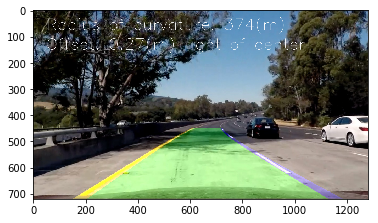

In [16]:
def process_image(img):
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    non_bin_warped, non_bin_M = perspective_shift(undist, src_corners, dest_corners)
    
    threshold = threshold_img(undist)
    
    bin_warped, M = perspective_shift(threshold, src_corners, dest_corners)
    
    inv_M = np.linalg.inv(M)
    
    with_lines, radcurv, offset = draw_curve_lines(img, undist, bin_warped, inv_M)
    
    with_lines = cv2.putText(
        with_lines,
        ('Radius of curvature: '+str(int(radcurv))+'(m)'),
        (50,75),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255,255,255),
        lineType=cv2.LINE_AA
    )
    
    offset_text = ('%.2f' % offset) + '(m) left of center' if offset < 0 else ('%.2f' % offset) + '(m) right of center'
    
    return cv2.putText(
        with_lines,
        ('Offset: '+ offset_text),
        (50,150),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255,255,255),
        lineType=cv2.LINE_AA
    )
        
t_image = cv2.imread('test_images/test5.jpg')
t_image = cv2.cvtColor(t_image, cv2.COLOR_BGR2RGB)
result = process_image(t_image)
plt.imshow(result)

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:53<00:00,  6.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 7s, sys: 1min 19s, total: 8min 27s
Wall time: 2min 53s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Challenge (WIP)

In [ ]:
challenge_video_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4").subclip(0, 5)
challenge_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

In [ ]:
x = [1,2,3]
y = [4,5,6]
print(np.stack((x,y), 1))